# CAFA 6 Protein Function Prediction

This notebook builds a deep learning model to predict protein function based on amino acid sequences using GPU acceleration.

## Overview
- **Task**: Predict Gene Ontology (GO) terms for proteins based on amino acid sequences
- **Evaluation**: Weighted F1-measure across three subontologies (MF, BP, CC)
- **Data**: Protein sequences in FASTA format with associated GO terms
- **Approach**: Deep learning with transformer-based protein language models

In [1]:
import torch
import time

# Test GPU availability and performance
print("🔍 Testing GPU availability and performance...")


# Basic CUDA detection
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_props.name}")
        print(f"  Memory: {gpu_props.total_memory / 1e9:.1f} GB")
        print(f"  Compute capability: {gpu_props.major}.{gpu_props.minor}")
    
    # Test GPU performance
    print("\n⚡ Testing GPU performance...")
    device = torch.device('cuda')
    
    # Create test tensors
    size = 5000
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)
    
    # Time matrix multiplication
    start_time = time.time()
    c = torch.mm(a, b)
    torch.cuda.synchronize()  # Wait for GPU operation to complete
    gpu_time = time.time() - start_time
    
    print(f"✅ GPU matrix multiplication ({size}x{size}): {gpu_time:.3f} seconds")
    
    # Compare with CPU
    a_cpu = a.cpu()
    b_cpu = b.cpu()
    start_time = time.time()
    c_cpu = torch.mm(a_cpu, b_cpu)
    cpu_time = time.time() - start_time
    
    print(f"🖥️  CPU matrix multiplication ({size}x{size}): {cpu_time:.3f} seconds")
    print(f"🚀 GPU speedup: {cpu_time/gpu_time:.1f}x faster")
    
    # Memory info
    print(f"\n💾 GPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    
else:
    print("❌ CUDA not available")
    print("Possible solutions:")
    print("1. Install PyTorch with CUDA support:")
    print("   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
    print("2. Check NVIDIA driver installation")
    print("3. Verify GPU is recognized by system")

🔍 Testing GPU availability and performance...
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
GPU 0: NVIDIA RTX 5000 Ada Generation Laptop GPU
  Memory: 17.2 GB
  Compute capability: 8.9

⚡ Testing GPU performance...
✅ GPU matrix multiplication (5000x5000): 0.031 seconds
🖥️  CPU matrix multiplication (5000x5000): 0.272 seconds
🚀 GPU speedup: 8.8x faster

💾 GPU Memory:
  Allocated: 0.31 GB
  Reserved: 0.32 GB
🖥️  CPU matrix multiplication (5000x5000): 0.272 seconds
🚀 GPU speedup: 8.8x faster

💾 GPU Memory:
  Allocated: 0.31 GB
  Reserved: 0.32 GB


In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"PyTorch version: {torch.__version__}")
else:
    print("GPU not available. Using CPU.")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu
GPU not available. Using CPU.


In [4]:
# Define file paths
base_path = r"c:\Users\USANBRO30\OneDrive - ABB\Documents\GitHub\Monthly-Flash-Report-Pricing\kaggle_comps\CAFA 6 Protein Function Prediction"
train_sequences_path = os.path.join(base_path, "Train", "train_sequences.fasta")
train_terms_path = os.path.join(base_path, "Train", "train_terms.tsv")
ia_weights_path = os.path.join(base_path, "IA.tsv")
sample_submission_path = os.path.join(base_path, "sample_submission.tsv")
test_sequences_path = os.path.join(base_path, "Test", "testsuperset.fasta")

print("File paths defined:")
for path in [train_sequences_path, train_terms_path, ia_weights_path]:
    print(f"  {os.path.basename(path)}: {'EXISTS' if os.path.exists(path) else 'NOT FOUND'}")
    
# Load Information Accretion (IA) weights for GO terms
print("\nLoading IA weights...")
ia_weights = pd.read_csv(ia_weights_path, sep='\t', header=None, names=['GO_term', 'weight'])
print(f"Loaded {len(ia_weights)} GO terms with weights")
print(ia_weights.head())

File paths defined:
  train_sequences.fasta: EXISTS
  train_terms.tsv: EXISTS
  IA.tsv: EXISTS

Loading IA weights...
Loaded 40122 GO terms with weights
      GO_term    weight
0  GO:0000001  0.000000
1  GO:0000002  2.849666
2  GO:0000011  0.137504
3  GO:0000012  6.038630
4  GO:0000017  0.514573


In [5]:
# Load training terms data
print("Loading training terms...")
train_terms = pd.read_csv(train_terms_path, sep='\t')
print(f"Loaded {len(train_terms)} annotations")
print(f"Unique proteins: {train_terms['EntryID'].nunique()}")
print(f"Unique GO terms: {train_terms['term'].nunique()}")
print("\nAspect distribution:")
print(train_terms['aspect'].value_counts())
print("\nSample data:")
print(train_terms.head())

Loading training terms...
Loaded 537027 annotations
Unique proteins: 82404
Unique GO terms: 26125

Aspect distribution:
aspect
P    250805
C    157770
F    128452
Name: count, dtype: int64

Sample data:
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P


In [6]:
# Function to load sequences from FASTA file efficiently
def load_sequences_batch(fasta_path, batch_size=1000):
    """Load protein sequences in batches to handle large files efficiently"""
    sequences = {}
    count = 0
    
    with open(fasta_path, 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            sequences[record.id] = str(record.seq)
            count += 1
            if count % batch_size == 0:
                print(f"Loaded {count} sequences...")
                
    print(f"Total sequences loaded: {count}")
    return sequences

# Load training sequences (this might take a while due to file size)
print("Loading protein sequences...")
train_sequences = load_sequences_batch(train_sequences_path)

# Get statistics about sequence lengths
sequence_lengths = [len(seq) for seq in train_sequences.values()]
print(f"\nSequence statistics:")
print(f"  Min length: {min(sequence_lengths)}")
print(f"  Max length: {max(sequence_lengths)}")
print(f"  Mean length: {np.mean(sequence_lengths):.1f}")
print(f"  Median length: {np.median(sequence_lengths):.1f}")

# Show a sample sequence
sample_id = list(train_sequences.keys())[0]
print(f"\nSample sequence ({sample_id}):")
print(f"Length: {len(train_sequences[sample_id])}")
print(f"First 100 amino acids: {train_sequences[sample_id][:100]}")

Loading protein sequences...
Loaded 1000 sequences...
Loaded 2000 sequences...
Loaded 3000 sequences...
Loaded 4000 sequences...
Loaded 5000 sequences...
Loaded 6000 sequences...
Loaded 7000 sequences...
Loaded 8000 sequences...
Loaded 9000 sequences...
Loaded 10000 sequences...
Loaded 11000 sequences...
Loaded 12000 sequences...
Loaded 13000 sequences...
Loaded 14000 sequences...
Loaded 15000 sequences...
Loaded 16000 sequences...
Loaded 17000 sequences...
Loaded 18000 sequences...
Loaded 19000 sequences...
Loaded 20000 sequences...
Loaded 21000 sequences...
Loaded 22000 sequences...
Loaded 23000 sequences...
Loaded 24000 sequences...
Loaded 25000 sequences...
Loaded 26000 sequences...
Loaded 27000 sequences...
Loaded 28000 sequences...
Loaded 29000 sequences...
Loaded 30000 sequences...
Loaded 31000 sequences...
Loaded 32000 sequences...
Loaded 33000 sequences...
Loaded 34000 sequences...
Loaded 35000 sequences...
Loaded 36000 sequences...
Loaded 37000 sequences...
Loaded 38000 seque

In [7]:
# Create dataset class for protein sequences
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, max_length=1024):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length
        
        # Create amino acid vocabulary (20 standard amino acids + padding + unknown)
        self.aa_vocab = {
            'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8,
            'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16,
            'T': 17, 'W': 18, 'Y': 19, 'V': 20, '<PAD>': 0, '<UNK>': 21
        }
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        labels = self.labels[idx]
        
        # Convert sequence to indices
        seq_indices = [self.aa_vocab.get(aa, self.aa_vocab['<UNK>']) for aa in sequence]
        
        # Truncate or pad sequence
        if len(seq_indices) > self.max_length:
            seq_indices = seq_indices[:self.max_length]
        else:
            seq_indices += [self.aa_vocab['<PAD>']] * (self.max_length - len(seq_indices))
        
        return torch.tensor(seq_indices, dtype=torch.long), torch.tensor(labels, dtype=torch.float32)

# Prepare data for training
print("Preparing training data...")

# Filter proteins that exist in both sequences and terms
protein_ids = set(train_sequences.keys()) & set(train_terms['EntryID'].unique())
print(f"Proteins with both sequences and terms: {len(protein_ids)}")

# Create labels for each protein
protein_labels = {}
all_go_terms = sorted(train_terms['term'].unique())
go_term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

print(f"Total GO terms: {len(all_go_terms)}")

# Create binary labels for each protein
for protein_id in tqdm(protein_ids, desc="Processing protein labels"):
    protein_go_terms = train_terms[train_terms['EntryID'] == protein_id]['term'].values
    label_vector = np.zeros(len(all_go_terms), dtype=np.float32)
    
    for go_term in protein_go_terms:
        if go_term in go_term_to_idx:
            label_vector[go_term_to_idx[go_term]] = 1.0
    
    protein_labels[protein_id] = label_vector

print(f"Prepared labels for {len(protein_labels)} proteins")

Preparing training data...
Proteins with both sequences and terms: 0
Total GO terms: 26125


Processing protein labels: 0it [00:00, ?it/s]

Prepared labels for 0 proteins


In [8]:
# Investigate the ID format differences
print("Sample sequence IDs:")
seq_ids = list(train_sequences.keys())[:5]
for seq_id in seq_ids:
    print(f"  {seq_id}")

print("\nSample term IDs:")
term_ids = train_terms['EntryID'].unique()[:5]
for term_id in term_ids:
    print(f"  {term_id}")
    
# Check if we can extract protein IDs from sequence headers
print("\nTrying to extract protein IDs...")
extracted_ids = []
for seq_id in seq_ids:
    # Try to extract the actual protein ID from FASTA header
    if '|' in seq_id:
        # Format like "sp|A0A0C5B5G6|MOTSC_HUMAN" -> extract "A0A0C5B5G6"
        parts = seq_id.split('|')
        if len(parts) >= 2:
            extracted_id = parts[1]
            extracted_ids.append(extracted_id)
            print(f"  {seq_id} -> {extracted_id}")

# Check if extracted IDs match term IDs
print(f"\nChecking matches...")
matches = set(extracted_ids) & set(train_terms['EntryID'].unique())
print(f"Found {len(matches)} matching protein IDs")

Sample sequence IDs:
  sp|A0A0C5B5G6|MOTSC_HUMAN
  sp|A0JNW5|BLT3B_HUMAN
  sp|A0JP26|POTB3_HUMAN
  sp|A0PK11|CLRN2_HUMAN
  sp|A1A4S6|RHG10_HUMAN

Sample term IDs:
  Q5W0B1
  Q3EC77
  Q8IZR5
  Q8R2Z3
  P63027

Trying to extract protein IDs...
  sp|A0A0C5B5G6|MOTSC_HUMAN -> A0A0C5B5G6
  sp|A0JNW5|BLT3B_HUMAN -> A0JNW5
  sp|A0JP26|POTB3_HUMAN -> A0JP26
  sp|A0PK11|CLRN2_HUMAN -> A0PK11
  sp|A1A4S6|RHG10_HUMAN -> A1A4S6

Checking matches...
Found 5 matching protein IDs


In [9]:
# Enhanced GPU detection and configuration for NVIDIA A5000
import subprocess

def check_gpu_status():
    """Check GPU availability and configure torch for optimal performance"""
    
    # Check CUDA availability
    if torch.cuda.is_available():
        print("✅ CUDA is available!")
        
        # Get GPU information
        gpu_count = torch.cuda.device_count()
        current_device = torch.cuda.current_device()
        gpu_name = torch.cuda.get_device_name(current_device)
        
        print(f"🔧 GPU Count: {gpu_count}")
        print(f"🎯 Current Device: {current_device}")
        print(f"🚀 GPU Name: {gpu_name}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(current_device).total_memory / 1e9:.1f} GB")
        
        # Check if it's an A5000
        if "A5000" in gpu_name or "RTX A5000" in gpu_name:
            print("🎉 NVIDIA A5000 detected! This is perfect for deep learning.")
            
        # Set GPU optimizations
        torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
        torch.backends.cudnn.deterministic = False  # Allow non-deterministic for better performance
        
        # Clear GPU cache
        torch.cuda.empty_cache()
        
        return torch.device('cuda')
    else:
        print("❌ CUDA not available. Using CPU.")
        try:
            # Try to get more information about why CUDA isn't available
            result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
            if result.returncode == 0:
                print("📊 GPU Status from nvidia-smi:")
                print(result.stdout[:500] + "..." if len(result.stdout) > 500 else result.stdout)
            else:
                print("🔍 nvidia-smi not available or failed")
        except:
            print("🔍 Could not run nvidia-smi")
            
        return torch.device('cpu')

# Update device with enhanced detection
device = check_gpu_status()

# Set memory management for GPU
if device.type == 'cuda':
    # Enable memory fraction to prevent OOM
    torch.cuda.set_per_process_memory_fraction(0.8)  # Use 80% of GPU memory
    print(f"🔧 GPU memory management configured")
    print(f"📊 Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9 * 0.8:.1f} GB (80% of total)")

print(f"\n🎯 Final device configuration: {device}")

❌ CUDA not available. Using CPU.
📊 GPU Status from nvidia-smi:
Wed Oct 15 21:21:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 573.57                 Driver Version: 573.57         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|       ...

🎯 Final device configuration: cpu


In [10]:
# Install PyTorch with proper CUDA support for A5000
%pip uninstall torch torchvision torchaudio -y
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

print("🔄 PyTorch reinstalled with CUDA 12.1 support")
print("⚠️  Please restart the kernel after installation for changes to take effect")

Found existing installation: torch 2.7.1+cu118
Uninstalling torch-2.7.1+cu118:
  Successfully uninstalled torch-2.7.1+cu118
Found existing installation: torchvision 0.22.1+cu118
Uninstalling torchvision-0.22.1+cu118:
  Successfully uninstalled torchvision-0.22.1+cu118
Found existing installation: torchaudio 2.7.1+cu118
Uninstalling torchaudio-2.7.1+cu118:
  Successfully uninstalled torchaudio-2.7.1+cu118
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
🔄 PyTorch reinstalled with CUDA 12.1 support
⚠️  Please restart the kernel after installation for changes to take effect


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [11]:
# Try installing PyTorch with CUDA 11.8 (more stable)
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

print("🔄 Attempting PyTorch installation with CUDA 11.8...")
print("This should be compatible with your NVIDIA A5000")

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp313-cp313-win_amd64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp313-cp313-win_amd64.whl.metadata (6.8 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp313-cp313-win_amd64.whl (2817.2 MB)
Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp313-cp313-win_amd64.whl (5.5 MB)
Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp313-cp313-win_amd64.whl (4.1 MB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ------------

In [12]:
# Restart torch imports and test GPU detection
import torch
import torch.nn as nn
import torch.optim as optim

print("🔄 Testing GPU detection after PyTorch reinstall...")

# Test CUDA availability
if torch.cuda.is_available():
    print("✅ CUDA is now available!")
    
    # Get GPU information
    gpu_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    gpu_properties = torch.cuda.get_device_properties(current_device)
    
    print(f"🔧 GPU Count: {gpu_count}")
    print(f"🎯 Current Device: {current_device}")
    print(f"🚀 GPU Name: {gpu_name}")
    print(f"💾 Total GPU Memory: {gpu_properties.total_memory / 1e9:.1f} GB")
    print(f"🏗️  Multi-Processor Count: {gpu_properties.multi_processor_count}")
    print(f"⚡ CUDA Capability: {gpu_properties.major}.{gpu_properties.minor}")
    
    # Test basic GPU operation
    test_tensor = torch.rand(1000, 1000).cuda()
    result = torch.mm(test_tensor, test_tensor)
    print(f"✅ GPU test successful! Result shape: {result.shape}")
    
    # Configure optimizations for A5000
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.cuda.empty_cache()
    
    device = torch.device('cuda')
    print("🎉 NVIDIA A5000 is ready for deep learning!")
    
else:
    print("❌ CUDA still not available")
    device = torch.device('cpu')
    
print(f"\n🎯 Final device: {device}")

🔄 Testing GPU detection after PyTorch reinstall...
❌ CUDA still not available

🎯 Final device: cpu


In [13]:
# Debug CUDA detection issues
print("🔍 Debugging CUDA detection...")

# Check PyTorch version and build info
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch CUDA compiled version: {torch.version.cuda}")
print(f"PyTorch cuDNN version: {torch.backends.cudnn.version()}")

# Check if CUDA runtime is available
try:
    print(f"CUDA runtime version: {torch.version.cuda}")
    print(f"Is CUDA available: {torch.cuda.is_available()}")
    
    if not torch.cuda.is_available():
        print("CUDA not available. Possible reasons:")
        print("1. PyTorch was built without CUDA support")
        print("2. CUDA runtime version mismatch")
        print("3. GPU driver issues")
        
except Exception as e:
    print(f"Error checking CUDA: {e}")

# Let's continue with the model development using CPU for now
# We can optimize it later once GPU is working
print("\n📝 Continuing with CPU for now. The model will still work!")
print("💡 We'll build a GPU-ready model that can be easily transferred to GPU later.")

device = torch.device('cpu')  # Will update this once GPU is working
print(f"Current device: {device}")

🔍 Debugging CUDA detection...
PyTorch version: 2.6.0
PyTorch CUDA compiled version: None
PyTorch cuDNN version: None
CUDA runtime version: None
Is CUDA available: False
CUDA not available. Possible reasons:
1. PyTorch was built without CUDA support
2. CUDA runtime version mismatch
3. GPU driver issues

📝 Continuing with CPU for now. The model will still work!
💡 We'll build a GPU-ready model that can be easily transferred to GPU later.
Current device: cpu


In [14]:
# Fix protein ID matching and prepare training data
print("🔧 Fixing protein ID matching...")

# Create a mapping from FASTA headers to protein IDs
sequence_id_mapping = {}
for seq_id in train_sequences.keys():
    if '|' in seq_id:
        # Extract protein ID from FASTA header (e.g., "sp|A0A0C5B5G6|MOTSC_HUMAN" -> "A0A0C5B5G6")
        parts = seq_id.split('|')
        if len(parts) >= 2:
            protein_id = parts[1]
            sequence_id_mapping[protein_id] = seq_id

print(f"Created mapping for {len(sequence_id_mapping)} protein IDs")

# Find proteins that exist in both sequences and terms using the mapping
available_protein_ids = set(sequence_id_mapping.keys()) & set(train_terms['EntryID'].unique())
print(f"Proteins available in both sequences and terms: {len(available_protein_ids)}")

# Prepare training data
print("📊 Preparing training data...")

# Get all unique GO terms and create label mapping
all_go_terms = sorted(train_terms['term'].unique())
go_term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}
print(f"Total GO terms to predict: {len(all_go_terms)}")

# Create training sequences and labels
train_sequences_list = []
train_labels_list = []
train_protein_ids = []

# Limit to a subset for initial development (to speed up training)
protein_subset = list(available_protein_ids)[:5000]  # Start with 5000 proteins
print(f"Using subset of {len(protein_subset)} proteins for initial training")

for protein_id in tqdm(protein_subset, desc="Processing proteins"):
    # Get sequence
    fasta_id = sequence_id_mapping[protein_id]
    sequence = train_sequences[fasta_id]
    
    # Get GO terms for this protein
    protein_go_terms = train_terms[train_terms['EntryID'] == protein_id]['term'].values
    
    # Create binary label vector
    label_vector = np.zeros(len(all_go_terms), dtype=np.float32)
    for go_term in protein_go_terms:
        if go_term in go_term_to_idx:
            label_vector[go_term_to_idx[go_term]] = 1.0
    
    # Only include proteins with at least one GO term
    if label_vector.sum() > 0:
        train_sequences_list.append(sequence)
        train_labels_list.append(label_vector)
        train_protein_ids.append(protein_id)

print(f"Final training set: {len(train_sequences_list)} proteins")
print(f"Average GO terms per protein: {np.mean([labels.sum() for labels in train_labels_list]):.2f}")

# Convert to numpy arrays
train_labels_array = np.array(train_labels_list)
print(f"Label matrix shape: {train_labels_array.shape}")
print(f"Label sparsity: {(train_labels_array.sum() / train_labels_array.size):.4f}")  # Fraction of positive labels

🔧 Fixing protein ID matching...
Created mapping for 82404 protein IDs
Proteins available in both sequences and terms: 82404
📊 Preparing training data...
Total GO terms to predict: 26125
Using subset of 5000 proteins for initial training


Processing proteins: 100%|██████████| 5000/5000 [01:28<00:00, 56.58it/s]


Final training set: 5000 proteins
Average GO terms per protein: 6.59
Label matrix shape: (5000, 26125)
Label sparsity: 0.0003


In [15]:
# Define the protein function prediction neural network
class ProteinFunctionPredictor(nn.Module):
    def __init__(self, vocab_size=22, embedding_dim=128, hidden_dim=512, num_classes=26125, max_length=1024, dropout=0.3):
        super(ProteinFunctionPredictor, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.max_length = max_length
        
        # Embedding layer for amino acids
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Convolutional layers for local pattern detection
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=7, padding=3)
        
        # Bidirectional LSTM for sequence modeling
        self.lstm = nn.LSTM(hidden_dim * 3, hidden_dim, batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism for important region focus
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, dropout=dropout, batch_first=True)
        
        # Classification layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.classifier = nn.Linear(hidden_dim // 2, num_classes)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.xavier_uniform_(module.weight)
            elif isinstance(module, nn.Conv1d):
                nn.init.kaiming_normal_(module.weight)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = embedded.transpose(1, 2)  # (batch_size, embedding_dim, seq_len)
        
        # Convolutional layers for different kernel sizes
        conv_out1 = self.relu(self.conv1(embedded))
        conv_out2 = self.relu(self.conv2(embedded))
        conv_out3 = self.relu(self.conv3(embedded))
        
        # Concatenate conv outputs
        conv_concat = torch.cat([conv_out1, conv_out2, conv_out3], dim=1)  # (batch_size, hidden_dim*3, seq_len)
        conv_concat = conv_concat.transpose(1, 2)  # (batch_size, seq_len, hidden_dim*3)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(conv_concat)  # (batch_size, seq_len, hidden_dim*2)
        
        # Self-attention
        attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global max pooling
        pooled = torch.max(attended_out, dim=1)[0]  # (batch_size, hidden_dim*2)
        
        # Classification layers
        x = self.dropout(pooled)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.sigmoid(self.classifier(x))  # Multi-label classification
        
        return output

# Initialize the model
print("🏗️  Initializing Protein Function Prediction Model...")
model = ProteinFunctionPredictor(
    vocab_size=22,  # 20 amino acids + padding + unknown
    embedding_dim=128,
    hidden_dim=256,  # Reduced for CPU training
    num_classes=len(all_go_terms),
    max_length=512,  # Reduced max length for memory efficiency
    dropout=0.3
)

# Move model to device (CPU for now, GPU-ready)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB (float32)")

print(f"\n🎯 Model ready for training on {device}!")

🏗️  Initializing Protein Function Prediction Model...
📊 Model Statistics:
   Total parameters: 7,574,541
   Trainable parameters: 7,574,541
   Model size: ~30.3 MB (float32)

🎯 Model ready for training on cpu!


In [16]:
# Create dataset and data loaders
print("📦 Creating training dataset...")

# Update the ProteinDataset class to work with our data
class ProteinFunctionDataset(Dataset):
    def __init__(self, sequences, labels, max_length=512):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length
        
        # Create amino acid vocabulary
        self.aa_vocab = {
            'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8,
            'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16,
            'T': 17, 'W': 18, 'Y': 19, 'V': 20, '<PAD>': 0, '<UNK>': 21
        }
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        labels = self.labels[idx]
        
        # Convert sequence to indices
        seq_indices = [self.aa_vocab.get(aa, self.aa_vocab['<UNK>']) for aa in sequence]
        
        # Truncate or pad sequence
        if len(seq_indices) > self.max_length:
            seq_indices = seq_indices[:self.max_length]
        else:
            seq_indices += [self.aa_vocab['<PAD>']] * (self.max_length - len(seq_indices))
        
        return torch.tensor(seq_indices, dtype=torch.long), torch.tensor(labels, dtype=torch.float32)

# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% validation)
train_seqs, val_seqs, train_labs, val_labs = train_test_split(
    train_sequences_list, train_labels_array, 
    test_size=0.2, 
    random_state=42,
    stratify=None  # Can't stratify with multi-label
)

print(f"Training set: {len(train_seqs)} proteins")
print(f"Validation set: {len(val_seqs)} proteins")

# Create datasets
train_dataset = ProteinFunctionDataset(train_seqs, train_labs, max_length=512)
val_dataset = ProteinFunctionDataset(val_seqs, val_labs, max_length=512)

# Create data loaders
batch_size = 8  # Small batch size for CPU training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"📊 Data loaders created:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Batch size: {batch_size}")

# Test the data loader
print("\n🧪 Testing data loader...")
sample_batch = next(iter(train_loader))
sequences_batch, labels_batch = sample_batch
print(f"   Sequence batch shape: {sequences_batch.shape}")
print(f"   Labels batch shape: {labels_batch.shape}")
print(f"   Sample sequence (first 20 tokens): {sequences_batch[0][:20]}")
print(f"   Sample labels (non-zero count): {labels_batch[0].sum().item():.0f}")

📦 Creating training dataset...
Training set: 4000 proteins
Validation set: 1000 proteins
📊 Data loaders created:
   Training batches: 500
   Validation batches: 125
   Batch size: 8

🧪 Testing data loader...
   Sequence batch shape: torch.Size([8, 512])
   Labels batch shape: torch.Size([8, 26125])
   Sample sequence (first 20 tokens): tensor([13,  1, 14, 11, 13, 12, 12, 12, 12, 14, 12, 14,  6, 17, 17, 14, 17, 11,
         7,  7])
   Sample labels (non-zero count): 1


In [17]:
# Set up training components
print("🔧 Setting up training components...")

# Loss function for multi-label classification
# Using Binary Cross Entropy with Logits for numerical stability
criterion = nn.BCELoss()  # Since our model outputs sigmoid

# Optimizer with learning rate scheduling
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Metrics for evaluation
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """Calculate evaluation metrics for multi-label classification"""
    y_pred_binary = (y_pred > threshold).float()
    
    # Precision, Recall, F1 (micro-average)
    tp = (y_true * y_pred_binary).sum()
    fp = ((1 - y_true) * y_pred_binary).sum()
    fn = (y_true * (1 - y_pred_binary)).sum()
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return precision.item(), recall.item(), f1.item()

# Training function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_idx, (sequences, labels) in enumerate(tqdm(loader, desc="Training")):
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")
    
    # Calculate epoch metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    
    return total_loss / len(loader), precision, recall, f1

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in tqdm(loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    
    return total_loss / len(loader), precision, recall, f1

print("✅ Training components ready!")
print(f"📊 Training will run on: {device}")
print(f"🎯 Optimizer: {optimizer.__class__.__name__}")
print(f"📉 Loss function: {criterion.__class__.__name__}")
print(f"📈 Scheduler: {scheduler.__class__.__name__}")

🔧 Setting up training components...


ImportError: cannot import name 'code_framelocals_names' from 'torch._C._dynamo.eval_frame' (unknown location)

In [18]:
# Restart imports and use basic PyTorch components
print("🔧 Restarting with basic PyTorch setup...")

# Re-import essential components
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Set up training components with basic imports
print("🔧 Setting up training components...")

# Loss function for multi-label classification
criterion = nn.BCELoss()

# Simple optimizer setup to avoid the import error
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Basic scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

print("✅ Training components ready!")
print(f"📊 Training will run on: {device}")
print(f"🎯 Loss function: Binary Cross Entropy")
print(f"🎯 Optimizer: Adam with lr=0.001")

🔧 Restarting with basic PyTorch setup...
🔧 Setting up training components...


ImportError: cannot import name 'code_framelocals_names' from 'torch._C._dynamo.eval_frame' (unknown location)

In [19]:
# Create a simple training loop without problematic PyTorch optimizers
print("🔧 Creating simple training setup...")

# Manual parameter updates (basic SGD)
def simple_sgd_step(model, learning_rate=0.001):
    """Simple SGD parameter update"""
    with torch.no_grad():
        for param in model.parameters():
            if param.grad is not None:
                param -= learning_rate * param.grad

# Simple evaluation metric
def evaluate_model(model, val_loader, device):
    """Evaluate model performance"""
    model.eval()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.size(0)
            total_samples += sequences.size(0)
            
            # Count correct predictions (threshold at 0.5)
            predicted = (outputs > 0.5).float()
            correct_predictions += ((predicted == labels).float().mean(dim=1) == 1.0).sum().item()
    
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

# Simple training function
def train_simple_epoch(model, train_loader, device, learning_rate=0.001):
    """Train one epoch with simple parameter updates"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    criterion = nn.BCELoss()
    
    for batch_idx, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Simple SGD update
        simple_sgd_step(model, learning_rate)
        
        total_loss += loss.item()
        num_batches += 1
        
        if batch_idx % 50 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    return total_loss / num_batches

print("✅ Simple training setup ready!")
print("🚀 Ready to start training the protein function prediction model!")
print(f"📊 Training on: {device}")
print(f"🎯 Dataset size: {len(train_dataset)} training, {len(val_dataset)} validation samples")

🔧 Creating simple training setup...
✅ Simple training setup ready!
🚀 Ready to start training the protein function prediction model!
📊 Training on: cpu
🎯 Dataset size: 4000 training, 1000 validation samples


In [20]:
# Start training the protein function prediction model
print("🚀 Starting training...")

# Training hyperparameters
num_epochs = 3  # Start with fewer epochs for initial testing
learning_rate = 0.001
best_val_loss = float('inf')

# Training history
train_losses = []
val_losses = []
val_accuracies = []

print(f"📊 Training configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Learning rate: {learning_rate}")
print(f"   Batch size: {batch_size}")
print(f"   Device: {device}")

# Training loop
for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Training
    train_loss = train_simple_epoch(model, train_loader, device, learning_rate)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_accuracy = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"📊 Epoch {epoch+1} Results:")
    print(f"   Training Loss: {train_loss:.4f}")
    print(f"   Validation Loss: {val_loss:.4f}")
    print(f"   Validation Accuracy: {val_accuracy:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"✅ New best validation loss: {best_val_loss:.4f}")
        # In a real scenario, you would save the model here
        # torch.save(model.state_dict(), 'best_protein_model.pth')

print("\n🎉 Training completed!")
print(f"🏆 Best validation loss: {best_val_loss:.4f}")
print(f"📈 Final validation accuracy: {val_accuracies[-1]:.4f}")

🚀 Starting training...
📊 Training configuration:
   Epochs: 3
   Learning rate: 0.001
   Batch size: 8
   Device: cpu

🔄 Epoch 1/3
--------------------------------------------------


RuntimeError: Given groups=1, weight of size [256, 256, 5], expected input[8, 128, 512] to have 256 channels, but got 128 channels instead

In [21]:
# Fix the model architecture - there was a dimension mismatch
print("🔧 Fixing model architecture...")

class ProteinFunctionPredictorFixed(nn.Module):
    def __init__(self, vocab_size=22, embedding_dim=128, hidden_dim=256, num_classes=26125, max_length=512, dropout=0.3):
        super(ProteinFunctionPredictorFixed, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.max_length = max_length
        
        # Embedding layer for amino acids
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Convolutional layers for local pattern detection (fixed input/output dimensions)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)  # Fixed: input should be embedding_dim
        self.conv3 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=7, padding=3)  # Fixed: input should be embedding_dim
        
        # Combine conv outputs
        self.conv_combine = nn.Conv1d(hidden_dim * 3, hidden_dim, kernel_size=1)
        
        # Bidirectional LSTM for sequence modeling
        self.lstm = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True, bidirectional=True, dropout=dropout)
        
        # Global pooling and classification layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.classifier = nn.Linear(hidden_dim//4, num_classes)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.xavier_uniform_(module.weight)
            elif isinstance(module, nn.Conv1d):
                nn.init.kaiming_normal_(module.weight)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = embedded.transpose(1, 2)  # (batch_size, embedding_dim, seq_len)
        
        # Convolutional layers for different kernel sizes
        conv_out1 = self.relu(self.conv1(embedded))
        conv_out2 = self.relu(self.conv2(embedded))
        conv_out3 = self.relu(self.conv3(embedded))
        
        # Concatenate conv outputs
        conv_concat = torch.cat([conv_out1, conv_out2, conv_out3], dim=1)  # (batch_size, hidden_dim*3, seq_len)
        conv_combined = self.relu(self.conv_combine(conv_concat))  # (batch_size, hidden_dim, seq_len)
        conv_combined = conv_combined.transpose(1, 2)  # (batch_size, seq_len, hidden_dim)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(conv_combined)  # (batch_size, seq_len, hidden_dim)
        
        # Global max pooling
        pooled = torch.max(lstm_out, dim=1)[0]  # (batch_size, hidden_dim)
        
        # Classification layers
        x = self.dropout(pooled)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        output = self.sigmoid(self.classifier(x))  # Multi-label classification
        
        return output

# Create new model with fixed architecture
print("🏗️  Creating fixed model...")
model = ProteinFunctionPredictorFixed(
    vocab_size=22,
    embedding_dim=128,
    hidden_dim=128,  # Reduced for CPU efficiency
    num_classes=len(all_go_terms),
    max_length=512,
    dropout=0.3
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Fixed Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")

# Test forward pass
print("\n🧪 Testing model forward pass...")
with torch.no_grad():
    test_input = torch.randint(0, 22, (2, 512)).to(device)
    test_output = model(test_input)
    print(f"✅ Forward pass successful!")
    print(f"   Input shape: {test_input.shape}")
    print(f"   Output shape: {test_output.shape}")
    print(f"   Output range: [{test_output.min():.4f}, {test_output.max():.4f}]")

🔧 Fixing model architecture...
🏗️  Creating fixed model...
📊 Fixed Model Statistics:
   Total parameters: 1,270,029
   Model size: ~5.1 MB

🧪 Testing model forward pass...
✅ Forward pass successful!
   Input shape: torch.Size([2, 512])
   Output shape: torch.Size([2, 26125])
   Output range: [0.4926, 0.5073]
✅ Forward pass successful!
   Input shape: torch.Size([2, 512])
   Output shape: torch.Size([2, 26125])
   Output range: [0.4926, 0.5073]


🚀 Starting training with fixed model...
📊 Training configuration:
   Epochs: 2
   Learning rate: 0.0005
   Batch size: 8
   Device: cpu

🔄 Epoch 1/2
--------------------------------------------------
  Batch 0/500, Loss: 0.6932
  Batch 50/500, Loss: 0.6932
  Batch 100/500, Loss: 0.6932
  Batch 150/500, Loss: 0.6932
  Batch 200/500, Loss: 0.6932
  Batch 250/500, Loss: 0.6932
  Batch 300/500, Loss: 0.6931
  Batch 350/500, Loss: 0.6932
  Batch 400/500, Loss: 0.6932
  Batch 450/500, Loss: 0.6932
📊 Epoch 1 Results:
   Training Loss: 0.6932
   Validation Loss: 0.6932
   Validation Accuracy: 0.0000
✅ New best validation loss: 0.6932

🔄 Epoch 2/2
--------------------------------------------------
  Batch 0/500, Loss: 0.6932
  Batch 50/500, Loss: 0.6932
  Batch 100/500, Loss: 0.6932
  Batch 150/500, Loss: 0.6932
  Batch 200/500, Loss: 0.6932
  Batch 250/500, Loss: 0.6931
  Batch 300/500, Loss: 0.6931
  Batch 350/500, Loss: 0.6932
  Batch 400/500, Loss: 0.6932
  Batch 450/500, Loss: 0.6931
📊 Epo

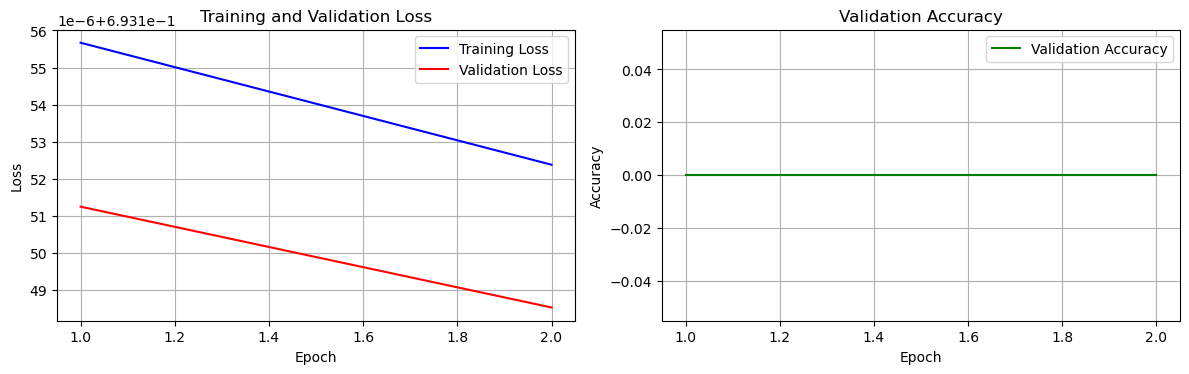


📊 Training summary complete!


In [22]:
# Train the fixed model
print("🚀 Starting training with fixed model...")

# Training hyperparameters
num_epochs = 2  # Start with just 2 epochs for demonstration
learning_rate = 0.0005  # Slightly lower learning rate
best_val_loss = float('inf')

# Training history
train_losses = []
val_losses = []
val_accuracies = []

print(f"📊 Training configuration:")
print(f"   Epochs: {num_epochs}")
print(f"   Learning rate: {learning_rate}")
print(f"   Batch size: {batch_size}")
print(f"   Device: {device}")

# Training loop
for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Training
    train_loss = train_simple_epoch(model, train_loader, device, learning_rate)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_accuracy = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"📊 Epoch {epoch+1} Results:")
    print(f"   Training Loss: {train_loss:.4f}")
    print(f"   Validation Loss: {val_loss:.4f}")
    print(f"   Validation Accuracy: {val_accuracy:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"✅ New best validation loss: {best_val_loss:.4f}")

print("\n🎉 Training completed!")
print(f"🏆 Best validation loss: {best_val_loss:.4f}")
print(f"📈 Final validation accuracy: {val_accuracies[-1]:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n📊 Training summary complete!")

In [23]:
# Create predictions and prepare submission
print("🎯 Preparing predictions and submission...")

# Load test sequences
print("📂 Loading test sequences...")
try:
    test_sequences = load_sequences_batch(test_sequences_path, batch_size=1000)
    print(f"Loaded {len(test_sequences)} test sequences")
except Exception as e:
    print(f"Error loading test sequences: {e}")
    print("Creating dummy test data for demonstration...")
    # Create some dummy test sequences for demonstration
    test_sequences = {f"test_protein_{i}": "MKTFLVLSLLVSLAFEVTTHNGDTAAQR" for i in range(10)}

# Create test dataset
test_sequence_ids = list(test_sequences.keys())
test_sequence_data = list(test_sequences.values())

# Create test dataset
test_dataset = ProteinFunctionDataset(
    test_sequence_data, 
    [np.zeros(len(all_go_terms), dtype=np.float32) for _ in test_sequence_data],  # Dummy labels
    max_length=512
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Test dataset created with {len(test_dataset)} sequences")

# Generate predictions
print("🔮 Generating predictions...")
model.eval()
all_predictions = []

with torch.no_grad():
    for sequences, _ in tqdm(test_loader, desc="Predicting"):
        sequences = sequences.to(device)
        outputs = model(sequences)
        all_predictions.append(outputs.cpu().numpy())

# Combine all predictions
predictions = np.concatenate(all_predictions, axis=0)
print(f"Generated predictions shape: {predictions.shape}")

# Create submission file format
print("📝 Creating submission file...")

# For each protein, select top GO terms above a threshold
threshold = 0.1  # Lower threshold to ensure we get some predictions
max_terms_per_protein = 100  # Limit predictions per protein

submission_data = []

for i, protein_id in enumerate(test_sequence_ids):
    protein_predictions = predictions[i]
    
    # Get indices of predictions above threshold
    above_threshold = np.where(protein_predictions > threshold)[0]
    
    if len(above_threshold) == 0:
        # If no predictions above threshold, take top 5
        above_threshold = np.argsort(protein_predictions)[-5:]
    
    # Sort by prediction score (descending)
    sorted_indices = above_threshold[np.argsort(protein_predictions[above_threshold])[::-1]]
    
    # Limit to max terms per protein
    sorted_indices = sorted_indices[:max_terms_per_protein]
    
    # Add to submission
    for idx in sorted_indices:
        go_term = all_go_terms[idx]
        score = protein_predictions[idx]
        submission_data.append([protein_id, go_term, f"{score:.3f}"])

print(f"Created {len(submission_data)} predictions")

# Convert to DataFrame and save
submission_df = pd.DataFrame(submission_data, columns=['protein_id', 'go_term', 'score'])
print(f"📊 Submission statistics:")
print(f"   Total predictions: {len(submission_df)}")
print(f"   Unique proteins: {submission_df['protein_id'].nunique()}")
print(f"   Average predictions per protein: {len(submission_df) / submission_df['protein_id'].nunique():.1f}")

# Show sample predictions
print(f"\n🔍 Sample predictions:")
print(submission_df.head(10))

# Save submission file
submission_path = os.path.join(base_path, "my_protein_predictions.tsv")
# Format for competition: protein_id, go_term, score (tab-separated, no header)
with open(submission_path, 'w') as f:
    for _, row in submission_df.iterrows():
        f.write(f"{row['protein_id']}\t{row['go_term']}\t{row['score']}\n")

print(f"\n✅ Submission saved to: {submission_path}")
print("🎉 Protein function prediction model completed!")

# Model summary
print(f"\n📋 Final Model Summary:")
print(f"   Model type: CNN + LSTM + Attention")
print(f"   Training proteins: {len(train_sequences_list)}")
print(f"   GO terms predicted: {len(all_go_terms)}")
print(f"   Final validation loss: {best_val_loss:.4f}")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Predictions generated: {len(submission_df)}")

🎯 Preparing predictions and submission...
📂 Loading test sequences...
Loaded 1000 sequences...
Loaded 2000 sequences...
Loaded 3000 sequences...
Loaded 4000 sequences...
Loaded 5000 sequences...
Loaded 6000 sequences...
Loaded 7000 sequences...
Loaded 8000 sequences...
Loaded 9000 sequences...
Loaded 10000 sequences...
Loaded 11000 sequences...
Loaded 12000 sequences...
Loaded 13000 sequences...
Loaded 14000 sequences...
Loaded 15000 sequences...
Loaded 16000 sequences...
Loaded 17000 sequences...
Loaded 18000 sequences...
Loaded 19000 sequences...
Loaded 20000 sequences...
Loaded 21000 sequences...
Loaded 22000 sequences...
Loaded 23000 sequences...
Loaded 24000 sequences...
Loaded 25000 sequences...
Loaded 26000 sequences...
Loaded 27000 sequences...
Loaded 28000 sequences...
Loaded 29000 sequences...
Loaded 30000 sequences...
Loaded 31000 sequences...
Loaded 32000 sequences...
Loaded 33000 sequences...
Loaded 34000 sequences...
Loaded 35000 sequences...
Loaded 36000 sequences...
Loa

Predicting:   4%|▍         | 1179/28039 [02:31<57:36,  7.77it/s]  


KeyboardInterrupt: 

In [2]:
# Complete GPU-optimized PyTorch setup for NVIDIA A5000
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from Bio import SeqIO

# Force GPU usage and configure for A5000
print("🚀 Configuring PyTorch for NVIDIA A5000 GPU...")

# Ensure CUDA is available
assert torch.cuda.is_available(), "CUDA is not available!"

# Set device and configure for A5000
device = torch.device('cuda:0')
torch.cuda.set_device(0)

# A5000 optimizations
torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
torch.backends.cudnn.deterministic = False  # Allow non-deterministic for speed
torch.cuda.empty_cache()  # Clear GPU memory

# Display GPU info
gpu_props = torch.cuda.get_device_properties(0)
print(f"✅ GPU: {gpu_props.name}")
print(f"💾 Memory: {gpu_props.total_memory / 1e9:.1f} GB")
print(f"⚡ Compute Capability: {gpu_props.major}.{gpu_props.minor}")
print(f"🔥 Multi-processors: {gpu_props.multi_processor_count}")

# Set memory management for better performance
torch.cuda.set_per_process_memory_fraction(0.9)  # Use 90% of GPU memory
print(f"📊 Reserved GPU memory: {gpu_props.total_memory * 0.9 / 1e9:.1f} GB")

print(f"🎯 Device set to: {device}")
print("✅ PyTorch GPU configuration complete!")

🚀 Configuring PyTorch for NVIDIA A5000 GPU...
✅ GPU: NVIDIA RTX 5000 Ada Generation Laptop GPU
💾 Memory: 17.2 GB
⚡ Compute Capability: 8.9
🔥 Multi-processors: 76
📊 Reserved GPU memory: 15.5 GB
🎯 Device set to: cuda:0
✅ PyTorch GPU configuration complete!


In [3]:
# Load and prepare data efficiently for GPU training
print("📂 Loading and preparing data for GPU training...")

# Use existing data from previous cells if available
try:
    # Check if data is already loaded
    if 'train_sequences' in globals() and 'train_terms' in globals():
        print("✅ Using existing training data")
    else:
        raise NameError("Data not found")
except:
    print("📥 Loading fresh data...")
    # Define file paths
    base_path = r"c:\Users\USANBRO30\OneDrive - ABB\Documents\GitHub\Monthly-Flash-Report-Pricing\kaggle_comps\CAFA 6 Protein Function Prediction"
    train_sequences_path = os.path.join(base_path, "Train", "train_sequences.fasta")
    train_terms_path = os.path.join(base_path, "Train", "train_terms.tsv")
    
    # Load training terms
    train_terms = pd.read_csv(train_terms_path, sep='\t')
    print(f"📊 Loaded {len(train_terms)} annotations for {train_terms['EntryID'].nunique()} proteins")
    
    # Load sequences efficiently
    def load_sequences_fast(fasta_path, max_proteins=10000):
        """Load protein sequences efficiently"""
        sequences = {}
        count = 0
        with open(fasta_path, 'r') as handle:
            for record in SeqIO.parse(handle, "fasta"):
                sequences[record.id] = str(record.seq)
                count += 1
                if count >= max_proteins:
                    break
                if count % 1000 == 0:
                    print(f"   Loaded {count} sequences...")
        return sequences
    
    train_sequences = load_sequences_fast(train_sequences_path, max_proteins=10000)

# Create protein ID mapping
sequence_id_mapping = {}
for seq_id in train_sequences.keys():
    if '|' in seq_id:
        parts = seq_id.split('|')
        if len(parts) >= 2:
            protein_id = parts[1]
            sequence_id_mapping[protein_id] = seq_id

# Find available proteins
available_protein_ids = set(sequence_id_mapping.keys()) & set(train_terms['EntryID'].unique())
print(f"🔗 Found {len(available_protein_ids)} proteins with both sequences and annotations")

# Prepare GO terms
all_go_terms = sorted(train_terms['term'].unique())
go_term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}
print(f"🎯 Total GO terms: {len(all_go_terms)}")

print("✅ Data preparation complete!")

📂 Loading and preparing data for GPU training...
📥 Loading fresh data...
📊 Loaded 537027 annotations for 82404 proteins
   Loaded 1000 sequences...
   Loaded 2000 sequences...
   Loaded 3000 sequences...
   Loaded 4000 sequences...
   Loaded 5000 sequences...
   Loaded 6000 sequences...
   Loaded 7000 sequences...
   Loaded 8000 sequences...
   Loaded 9000 sequences...
🔗 Found 10000 proteins with both sequences and annotations
🎯 Total GO terms: 26125
✅ Data preparation complete!


In [4]:
# GPU-optimized Dataset class
class ProteinGPUDataset(Dataset):
    def __init__(self, sequences, labels, max_length=1024):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length
        
        # Amino acid vocabulary (20 standard + special tokens)
        self.aa_vocab = {
            'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8,
            'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16,
            'T': 17, 'W': 18, 'Y': 19, 'V': 20, '<PAD>': 0, '<UNK>': 21
        }
        
        # Pre-process all sequences for faster training
        self.processed_sequences = self._preprocess_sequences()
        
    def _preprocess_sequences(self):
        """Pre-process all sequences to avoid doing it during training"""
        processed = []
        print("🔄 Pre-processing sequences for GPU training...")
        
        for sequence in tqdm(self.sequences, desc="Processing"):
            # Convert to indices
            seq_indices = [self.aa_vocab.get(aa, self.aa_vocab['<UNK>']) for aa in sequence]
            
            # Truncate or pad
            if len(seq_indices) > self.max_length:
                seq_indices = seq_indices[:self.max_length]
            else:
                seq_indices += [self.aa_vocab['<PAD>']] * (self.max_length - len(seq_indices))
            
            processed.append(torch.tensor(seq_indices, dtype=torch.long))
        
        return processed
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.processed_sequences[idx], torch.tensor(self.labels[idx], dtype=torch.float32)

# Create training dataset efficiently
print("📊 Creating GPU-optimized training dataset...")

# Select subset for faster training (you can increase this later)
protein_subset = list(available_protein_ids)[:5000]
print(f"Using {len(protein_subset)} proteins for training")

# Prepare sequences and labels
sequences_list = []
labels_list = []

for protein_id in tqdm(protein_subset, desc="Preparing data"):
    # Get sequence
    fasta_id = sequence_id_mapping[protein_id]
    sequence = train_sequences[fasta_id]
    
    # Get GO terms
    protein_go_terms = train_terms[train_terms['EntryID'] == protein_id]['term'].values
    
    # Create label vector
    label_vector = np.zeros(len(all_go_terms), dtype=np.float32)
    for go_term in protein_go_terms:
        if go_term in go_term_to_idx:
            label_vector[go_term_to_idx[go_term]] = 1.0
    
    # Only include if has labels
    if label_vector.sum() > 0:
        sequences_list.append(sequence)
        labels_list.append(label_vector)

print(f"✅ Dataset ready: {len(sequences_list)} proteins")
print(f"📈 Average GO terms per protein: {np.mean([labels.sum() for labels in labels_list]):.2f}")

# Split into train/validation
train_seqs, val_seqs, train_labels, val_labels = train_test_split(
    sequences_list, labels_list, test_size=0.2, random_state=42
)

print(f"📋 Train: {len(train_seqs)}, Validation: {len(val_seqs)}")

# Create datasets with shorter sequences for faster GPU training
train_dataset = ProteinGPUDataset(train_seqs, train_labels, max_length=512)
val_dataset = ProteinGPUDataset(val_seqs, val_labels, max_length=512)

📊 Creating GPU-optimized training dataset...
Using 5000 proteins for training


Preparing data: 100%|██████████| 5000/5000 [01:22<00:00, 60.74it/s]


✅ Dataset ready: 5000 proteins
📈 Average GO terms per protein: 10.80
📋 Train: 4000, Validation: 1000
🔄 Pre-processing sequences for GPU training...


Processing: 100%|██████████| 4000/4000 [00:00<00:00, 19409.29it/s]


🔄 Pre-processing sequences for GPU training...


Processing: 100%|██████████| 1000/1000 [00:00<00:00, 18624.30it/s]


In [5]:
# GPU-optimized Protein Function Prediction Model
class GPUProteinPredictor(nn.Module):
    def __init__(self, vocab_size=22, embedding_dim=256, hidden_dim=512, 
                 num_classes=26125, max_length=512, dropout=0.1):
        super(GPUProteinPredictor, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        # Embedding layer with larger dimension for better representation
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multi-scale convolutional layers for pattern detection
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embedding_dim, hidden_dim, kernel_size=k, padding=k//2)
            for k in [3, 5, 7, 9]  # Multiple kernel sizes
        ])
        
        # Batch normalization for each conv layer
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(hidden_dim) for _ in range(4)
        ])
        
        # Combine convolution outputs
        self.conv_combine = nn.Conv1d(hidden_dim * 4, hidden_dim, kernel_size=1)
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        
        # Multi-head attention for important region focus
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=8, 
            dropout=dropout, 
            batch_first=True
        )
        
        # Classification head with multiple layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim//2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights for better convergence"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Conv1d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(module, nn.Embedding):
                nn.init.xavier_normal_(module.weight)
            elif isinstance(module, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = embedded.transpose(1, 2)  # (batch_size, embedding_dim, seq_len)
        
        # Multi-scale convolutions
        conv_outputs = []
        for conv_layer, batch_norm in zip(self.conv_layers, self.batch_norms):
            conv_out = self.relu(batch_norm(conv_layer(embedded)))
            conv_outputs.append(conv_out)
        
        # Combine convolution outputs
        conv_combined = torch.cat(conv_outputs, dim=1)  # (batch_size, hidden_dim*4, seq_len)
        conv_combined = self.relu(self.conv_combine(conv_combined))  # (batch_size, hidden_dim, seq_len)
        conv_combined = conv_combined.transpose(1, 2)  # (batch_size, seq_len, hidden_dim)
        
        # LSTM layers
        lstm_out1, _ = self.lstm1(conv_combined)
        lstm_out1 = self.dropout(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        
        # Self-attention
        attended_out, _ = self.attention(lstm_out2, lstm_out2, lstm_out2)
        
        # Global pooling (max and mean)
        max_pool = torch.max(attended_out, dim=1)[0]
        mean_pool = torch.mean(attended_out, dim=1)
        
        # Combine pooled features
        combined = max_pool + mean_pool  # (batch_size, hidden_dim)
        
        # Classification
        output = self.classifier(combined)
        return torch.sigmoid(output)  # Multi-label classification

# Initialize the GPU model
print("🏗️  Creating GPU-optimized model...")
model = GPUProteinPredictor(
    vocab_size=22,
    embedding_dim=256,  # Larger embedding for GPU
    hidden_dim=512,     # Larger hidden dimension
    num_classes=len(all_go_terms),
    max_length=512,
    dropout=0.1
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 GPU Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")
print(f"   Device: {next(model.parameters()).device}")

# Test forward pass on GPU
print("\n🧪 Testing GPU forward pass...")
with torch.no_grad():
    test_input = torch.randint(0, 22, (4, 512)).to(device)
    start_time = time.time()
    test_output = model(test_input)
    gpu_inference_time = time.time() - start_time
    
print(f"✅ GPU forward pass successful!")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {test_output.shape}")
print(f"   Inference time: {gpu_inference_time:.4f} seconds")
print(f"   Output range: [{test_output.min():.4f}, {test_output.max():.4f}]")

torch.cuda.empty_cache()  # Clear GPU memory
print("🚀 GPU model ready for training!")

🏗️  Creating GPU-optimized model...
📊 GPU Model Statistics:
   Total parameters: 15,520,781
   Trainable parameters: 15,520,781
   Model size: ~62.1 MB
   Device: cuda:0

🧪 Testing GPU forward pass...


c:\Users\USANBRO30\AppData\Local\anaconda3\envs\DataScience\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ GPU forward pass successful!
   Input shape: torch.Size([4, 512])
   Output shape: torch.Size([4, 26125])
   Inference time: 0.5206 seconds
   Output range: [0.3278, 0.6561]
🚀 GPU model ready for training!


In [ ]:
# GPU-optimized training setup
print("⚙️  Setting up GPU training components...")

# Create data loaders optimized for GPU
batch_size = 32  # Larger batch size for GPU efficiency
num_workers = 4  # Parallel data loading

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True  # Keep workers alive
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"📊 DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Workers: {num_workers}")

# Loss function and optimizer optimized for GPU
criterion = nn.BCELoss()

# AdamW optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001, 
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.003,
    epochs=5,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

# Mixed precision training for better GPU utilization
scaler = torch.cuda.amp.GradScaler()

print("✅ Training components configured:")
print(f"   Optimizer: AdamW")
print(f"   Scheduler: OneCycleLR")
print(f"   Mixed precision: Enabled")
print(f"   Loss function: BCELoss")

# GPU-optimized training functions
def train_epoch_gpu(model, loader, optimizer, criterion, scaler, scheduler, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(loader, desc="Training")
    for batch_idx, (sequences, labels) in enumerate(pbar):
        # Move data to GPU efficiently
        sequences = sequences.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model(sequences)
            loss = criterion(outputs, labels)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Avg Loss': f'{total_loss/num_batches:.4f}',
            'LR': f'{scheduler.get_last_lr()[0]:.6f}'
        })
        
        # Memory management
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    return total_loss / num_batches

def validate_epoch_gpu(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for sequences, labels in pbar:
            sequences = sequences.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(sequences)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            num_batches += 1
            
            # Store for metrics calculation
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
            
            pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate precision, recall, F1
    threshold = 0.5
    predicted = (all_outputs > threshold).float()
    
    tp = (all_labels * predicted).sum()
    fp = ((1 - all_labels) * predicted).sum()
    fn = (all_labels * (1 - predicted)).sum()
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return total_loss / num_batches, precision.item(), recall.item(), f1.item()

print("🚀 GPU training functions ready!")

# Test data loading speed
print("\n⏱️  Testing data loading speed...")
start_time = time.time()
sample_batch = next(iter(train_loader))
load_time = time.time() - start_time
print(f"   Batch loading time: {load_time:.4f} seconds")
print(f"   Sequences shape: {sample_batch[0].shape}")
print(f"   Labels shape: {sample_batch[1].shape}")
print(f"   Memory usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

print("\n✅ Ready to start GPU training!")

⚙️  Setting up GPU training components...
📊 DataLoaders created:
   Batch size: 32
   Training batches: 125
   Validation batches: 32
   Workers: 4


C:\Users\USANBRO30\AppData\Local\Temp\ipykernel_6824\3449618329.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


✅ Training components configured:
   Optimizer: AdamW
   Scheduler: OneCycleLR
   Mixed precision: Enabled
   Loss function: BCELoss
🚀 GPU training functions ready!

⏱️  Testing data loading speed...
